In [1]:
from rdkit import Chem
import psycopg2
import pandas as pd
import psycopg2
hostname = 'scotland'
dbname = 'cs_mdfps'
username = 'cschiebroek'
import warnings
# Suppress the FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)
from rdkit.Chem import Descriptors
from rdkit.Chem.Descriptors import CalcMolDescriptors
import sys
sys.path.append('../..')
from carl import utils_carl
from carl.utils_carl import train_pred_xgboost_2d, getStatValues,density_plot, get_mdfps
from functools import reduce

In [2]:
import sys
sys.path.append('../..')
from carl import utils_carl
from carl.utils_carl import train_pred_xgboost_2d, getStatValues,density_plot, get_mdfps
from functools import reduce

In [3]:
df = pd.read_csv('mdfp_and_rdkit_features_all_mols.csv')
df

,Unnamed: 0,confid,molregno,mdfp,vp,NumHeavyAtoms,NumRotatableBonds,NumN,NumO,NumF,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,2388,2390,"[10, 1, 0, 0, 0, 0, 0, 0, 0, 0, -24.3637634540...",-0.674795,10,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2394,2396,"[7, 4, 0, 1, 0, 0, 0, 0, 0, 0, -4.742220929815...",-0.907920,7,4,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2400,2402,"[10, 2, 2, 0, 0, 0, 0, 0, 0, 0, -13.4724999801...",-3.000000,10,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,2406,2408,"[14, 3, 4, 3, 0, 0, 0, 0, 0, 0, -411.884680244...",-6.822020,14,3,4,3,0,...,0,0,0,0,0,0,0,0,0,1
4,4,2411,2413,"[15, 2, 0, 1, 0, 0, 0, 0, 2, 0, -36.3113182099...",-4.772345,15,2,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3014,3014,4239,4241,"[17, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0.034004099168...",-8.356584,17,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3015,3015,4240,4242,"[19, 2, 0, 1, 0, 0, 0, 6, 0, 0, -30.8042543707...",-6.770000,19,2,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3016,3016,4242,4244,"[18, 1, 0, 1, 0, 0, 0, 0, 0, 0, -99.4284026602...",2.397940,18,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3017,3017,4243,1087,"[10, 4, 0, 5, 0, 0, 0, 0, 0, 0, 213.0930717038...",-10.580632,10,4,0,5,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
params = {
    # Parameters that we are going to tune.
    'max_depth':3,
    'min_child_weight': 6,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    "objective" : 'reg:squarederror',
}
#load X features: carl/RDKit_2D_descriptors.pkl
RDKit_feature_names = pd.read_pickle('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/outputs/RDKit_2D_descriptors.pkl')
output_2d_only = train_pred_xgboost_2d(df,params=params,X_features=RDKit_feature_names,y_label='vp')
real_2d_only, prediction_2d_only = (reduce(lambda a,b : list(a)+list(b) , output_2d_only[0]), reduce(lambda a,b : list(a)+list(b), output_2d_only[1]))
mdfp_features_no_2d = ['water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean', 'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std', 'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median', 'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean', 'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std', 'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']
output_combined = train_pred_xgboost_2d(df,params=params,X_features=RDKit_feature_names+mdfp_features_no_2d,y_label='vp')
real_combined, prediction_combined = (reduce(lambda a,b : list(a)+list(b) , output_combined[0]), reduce(lambda a,b : list(a)+list(b), output_combined[1]))

Plot 1 Stats:
RMSE:  1.2240529735051782
MAE:  0.7530258437360301
R2:  0.8852345251786184
Plot 2 Stats:
RMSE:  1.2590723965498132
MAE:  0.7740378662771044
R2:  0.8786242264492747


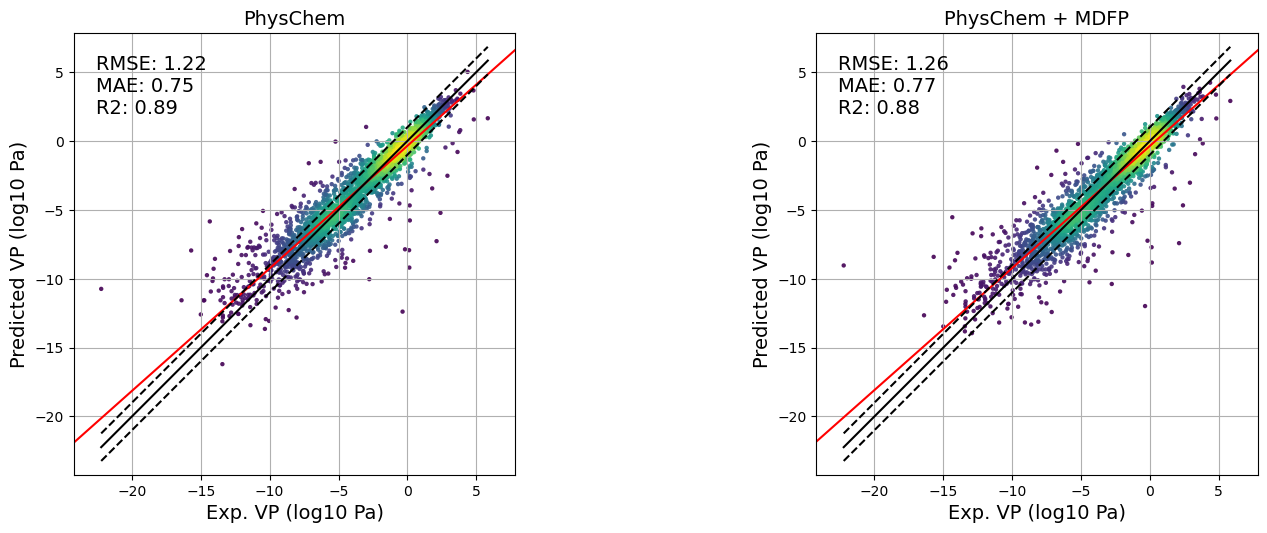

In [8]:
from carl.utils_carl import density_plot_multiple
density_plot_multiple(reals = [real_2d_only,real_combined],predictions=[prediction_2d_only,prediction_combined],titles = ['PhysChem','PhysChem + MDFP'])

In [9]:
#okay, now I actually want to look at prediction error of only 2d vs only mdfp per mol, and look at the difference
params = { #hyperparameters optimized by ShuZe Wang
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}
import numpy as np
from sklearn.model_selection import GroupKFold, KFold
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
gkf = GroupKFold(n_splits=5)

# Create an empty list to store the indices of each fold
fold_indices = []
# Group the data by 'molregno'
groups = df['molregno']

# Iterate over each fold
for train_idx, test_idx in gkf.split(df, groups=groups):
    fold_indices.append((train_idx, test_idx))
mdfp_features_all = ['NumHeavyAtoms', 'NumRotatableBonds', 'NumN', 'NumO', 'NumF', 'NumP', 'NumS', 'NumCl', 'NumBr', 'NumI', 'water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean', 'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std', 'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median', 'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean', 'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std', 'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']

y = df['vp']  
params = params
output = ([],[],[],[],[])
selection_2d_features = RDKit_feature_names

X_mdfp = df[mdfp_features_all]
X_mdfp = StandardScaler().fit_transform(X_mdfp)
X_2d = df[selection_2d_features]
X_2d = StandardScaler().fit_transform(X_2d)
y = df['vp']
# Iterate over each fold
for fold, (train_idx, test_idx) in enumerate(fold_indices):

    #get the train and test data
    X_train_mdfp = X_mdfp[train_idx]
    X_test_mdfp = X_mdfp[test_idx]
    X_train_2d = X_2d[train_idx]
    X_test_2d = X_2d[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]



    # Create DMatrix for training and testing
    dtrain_mdfp = xgb.DMatrix(X_train_mdfp, label=y_train)
    dtest_mdfp = xgb.DMatrix(X_test_mdfp, label=y_test)

    dtrain_2d = xgb.DMatrix(X_train_2d, label=y_train)
    dtest_2d = xgb.DMatrix(X_test_2d, label=y_test)


    model_mdfp = xgb.train(
        params,
        dtrain_mdfp,
        num_boost_round=999,
        evals=[(dtest_mdfp, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False

    )

    model_2d = xgb.train(
        params,
        dtrain_2d,
        num_boost_round=999,
        evals=[(dtest_2d, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False

    )
    pp_mdfp = model_mdfp.predict(dtest_mdfp)
    pp_2d = model_2d.predict(dtest_2d)

    output[0].append(y_test)
    output[1].append(pp_mdfp)
    molregnos_test = df['molregno'].iloc[test_idx]
    confids_test = df['confid'].iloc[test_idx]
    
    output[2].append(molregnos_test)
    output[3].append(confids_test)
    output[4].append(pp_2d)

    rmse_mdfp = np.sqrt(mean_squared_error(y_test, pp_mdfp, squared=False))
    rmse_2d = np.sqrt(mean_squared_error(y_test, pp_2d, squared=False))
    print(f"Fold {fold + 1}: MDFP RMSE = {rmse_mdfp}, 2D RMSE = {rmse_2d}")



Fold 1: MDFP RMSE = 1.2120086081380206, 2D RMSE = 1.1691916997618543
Fold 2: MDFP RMSE = 1.1813995099300418, 2D RMSE = 1.1095116060746109
Fold 3: MDFP RMSE = 1.1496915511718304, 2D RMSE = 1.067365484561534
Fold 4: MDFP RMSE = 1.2512689517410922, 2D RMSE = 1.1447116971549225
Fold 5: MDFP RMSE = 1.1284805903962247, 2D RMSE = 1.0228052596196315


In [10]:
#average over conformers
vps = reduce(lambda a,b : list(a)+list(b) , output[0])
preds_mdfp = reduce(lambda a,b : list(a)+list(b), output[1])
molregnos = reduce(lambda a,b : list(a)+list(b), output[2])
confids = reduce(lambda a,b : list(a)+list(b), output[3])
preds_2d = reduce(lambda a,b : list(a)+list(b), output[4])

df_preds = pd.DataFrame({'vp': vps, 'pred_mdfp': preds_mdfp, 'pred_2d': preds_2d, 'confid': confids, 'molregno': molregnos})
df_preds = df_preds.groupby('molregno').mean()
#drop confid
df_preds = df_preds.drop(columns=['confid'])
#get abs error for both preds
df_preds['abs_error_mdfp'] = abs(df_preds['vp'] - df_preds['pred_mdfp'])
df_preds['abs_error_2d'] = abs(df_preds['vp'] - df_preds['pred_2d'])
df_preds

,vp,pred_mdfp,pred_2d,abs_error_mdfp,abs_error_2d
molregno,,,,,
1,1.100855,1.561785,0.843428,0.460930,0.257427
6,-14.744727,-11.033422,-8.154742,3.711305,6.589985
7,-0.301067,-0.427523,0.269263,0.126456,0.570330
8,-6.053323,-6.347808,-6.229554,0.294486,0.176231
9,0.591625,0.559341,1.270787,0.032284,0.679163
...,...,...,...,...,...
4240,-7.301899,-6.990613,-6.888975,0.311286,0.412924
4241,-8.356584,-7.680636,-7.623059,0.675948,0.733525
4242,-6.770000,-6.363488,-6.761322,0.406512,0.008678


Plot 1 Stats:
RMSE:  1.409016617528164
MAE:  0.8751584984820857
R2:  0.8479816863508847
Plot 2 Stats:
RMSE:  1.2242682386440848
MAE:  0.7290184684561803
R2:  0.8852272352494398


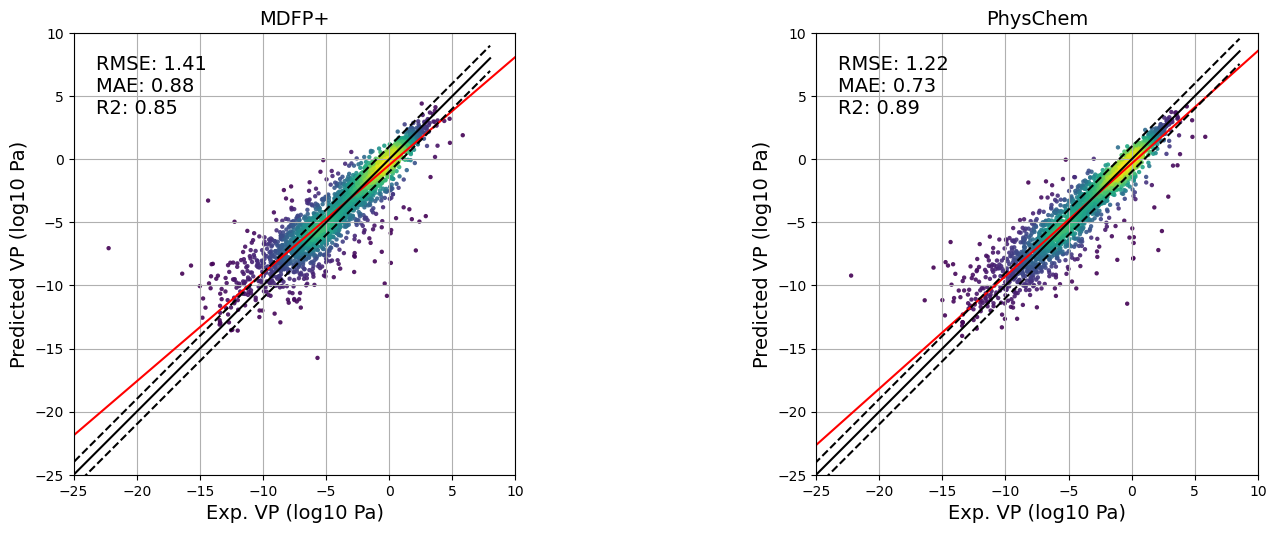

In [11]:
#plot these two
density_plot_multiple(reals = [df_preds['vp'],df_preds['vp']],predictions=[df_preds['pred_mdfp'],df_preds['pred_2d']],titles = ['MDFP+','PhysChem'],bounds=[-25,10])

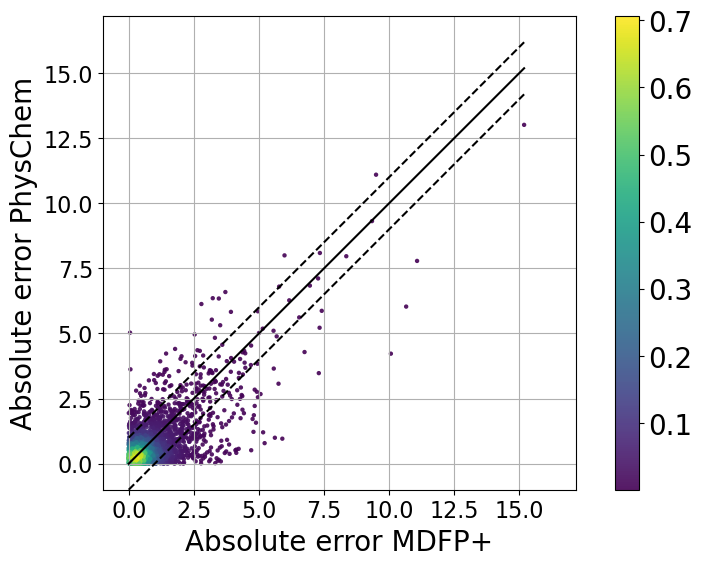

In [12]:
import matplotlib.pyplot as plt

fsize = 20
real = df_preds['abs_error_mdfp'].tolist()
prediction = df_preds['abs_error_2d'].tolist()
fig = plt.figure(1, figsize=(10, 6.15))
ax = plt.subplot(111)
lower = -1
upper = max(prediction + real) + 2
x = np.linspace(lower, upper,len(real))
plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real), max(prediction + real)], 'k-')
plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real)-1, max(prediction + real) - 1], 'k--')
plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real)+1, max(prediction + real)+1], 'k--')

import statsmodels.api as sm
dens_u = sm.nonparametric.KDEMultivariate(data=[real, prediction],var_type='cc', bw='normal_reference')
z = dens_u.pdf([real, prediction])

sc = plt.scatter(real, prediction, lw=0, c=z, s=10, alpha = 0.9)

cbar = plt.colorbar(sc)
cbar.ax.tick_params(labelsize=fsize)

plt.xlabel(r'Absolute error MDFP+', fontsize=fsize)
plt.ylabel(r'Absolute error PhysChem', fontsize=fsize)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
plt.grid(1,"both")
plt.axis([lower, upper, lower, upper])
#make square
ax.set_aspect('equal', 'box')
plt.show()

In [13]:
#get df for points were mdfp is better then 2d
df_mdfp_better = df_preds[df_preds['abs_error_mdfp'] < df_preds['abs_error_2d']]
print(len(df_mdfp_better))
df_mdfp_better
molregnos_mdfp_better = df_mdfp_better.index.tolist()

1287


In [14]:
df_mdfp_better #sort by where abs_error_mdfp is most smaller then abs_error_2d
df_mdfp_better = df_mdfp_better.sort_values(by=['abs_error_mdfp'])
df_mdfp_better

,vp,pred_mdfp,pred_2d,abs_error_mdfp,abs_error_2d
molregno,,,,,
2782,-4.744727,-4.744841,-3.946617,0.000114,0.798110
4088,-2.975442,-2.975664,-2.669441,0.000223,0.306001
3679,-0.852932,-0.852552,-0.767950,0.000379,0.084982
99,-3.050322,-3.049737,-2.809911,0.000584,0.240411
550,-5.930000,-5.930647,-5.765417,0.000647,0.164583
...,...,...,...,...,...
1034,0.162328,-5.612693,-6.636268,5.775021,6.798596
535,0.120537,-5.861460,-7.876270,5.981997,7.996807
3139,-2.771294,-8.934660,-9.042356,6.163365,6.271061


In [15]:
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()
cur.execute("SELECT * FROM cs_mdfps_schema.experimental_data WHERE molregno IN %s", (tuple(molregnos_mdfp_better),))
data = cur.fetchall()
smiles = [x[4]['SMILES'] for x in data]

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


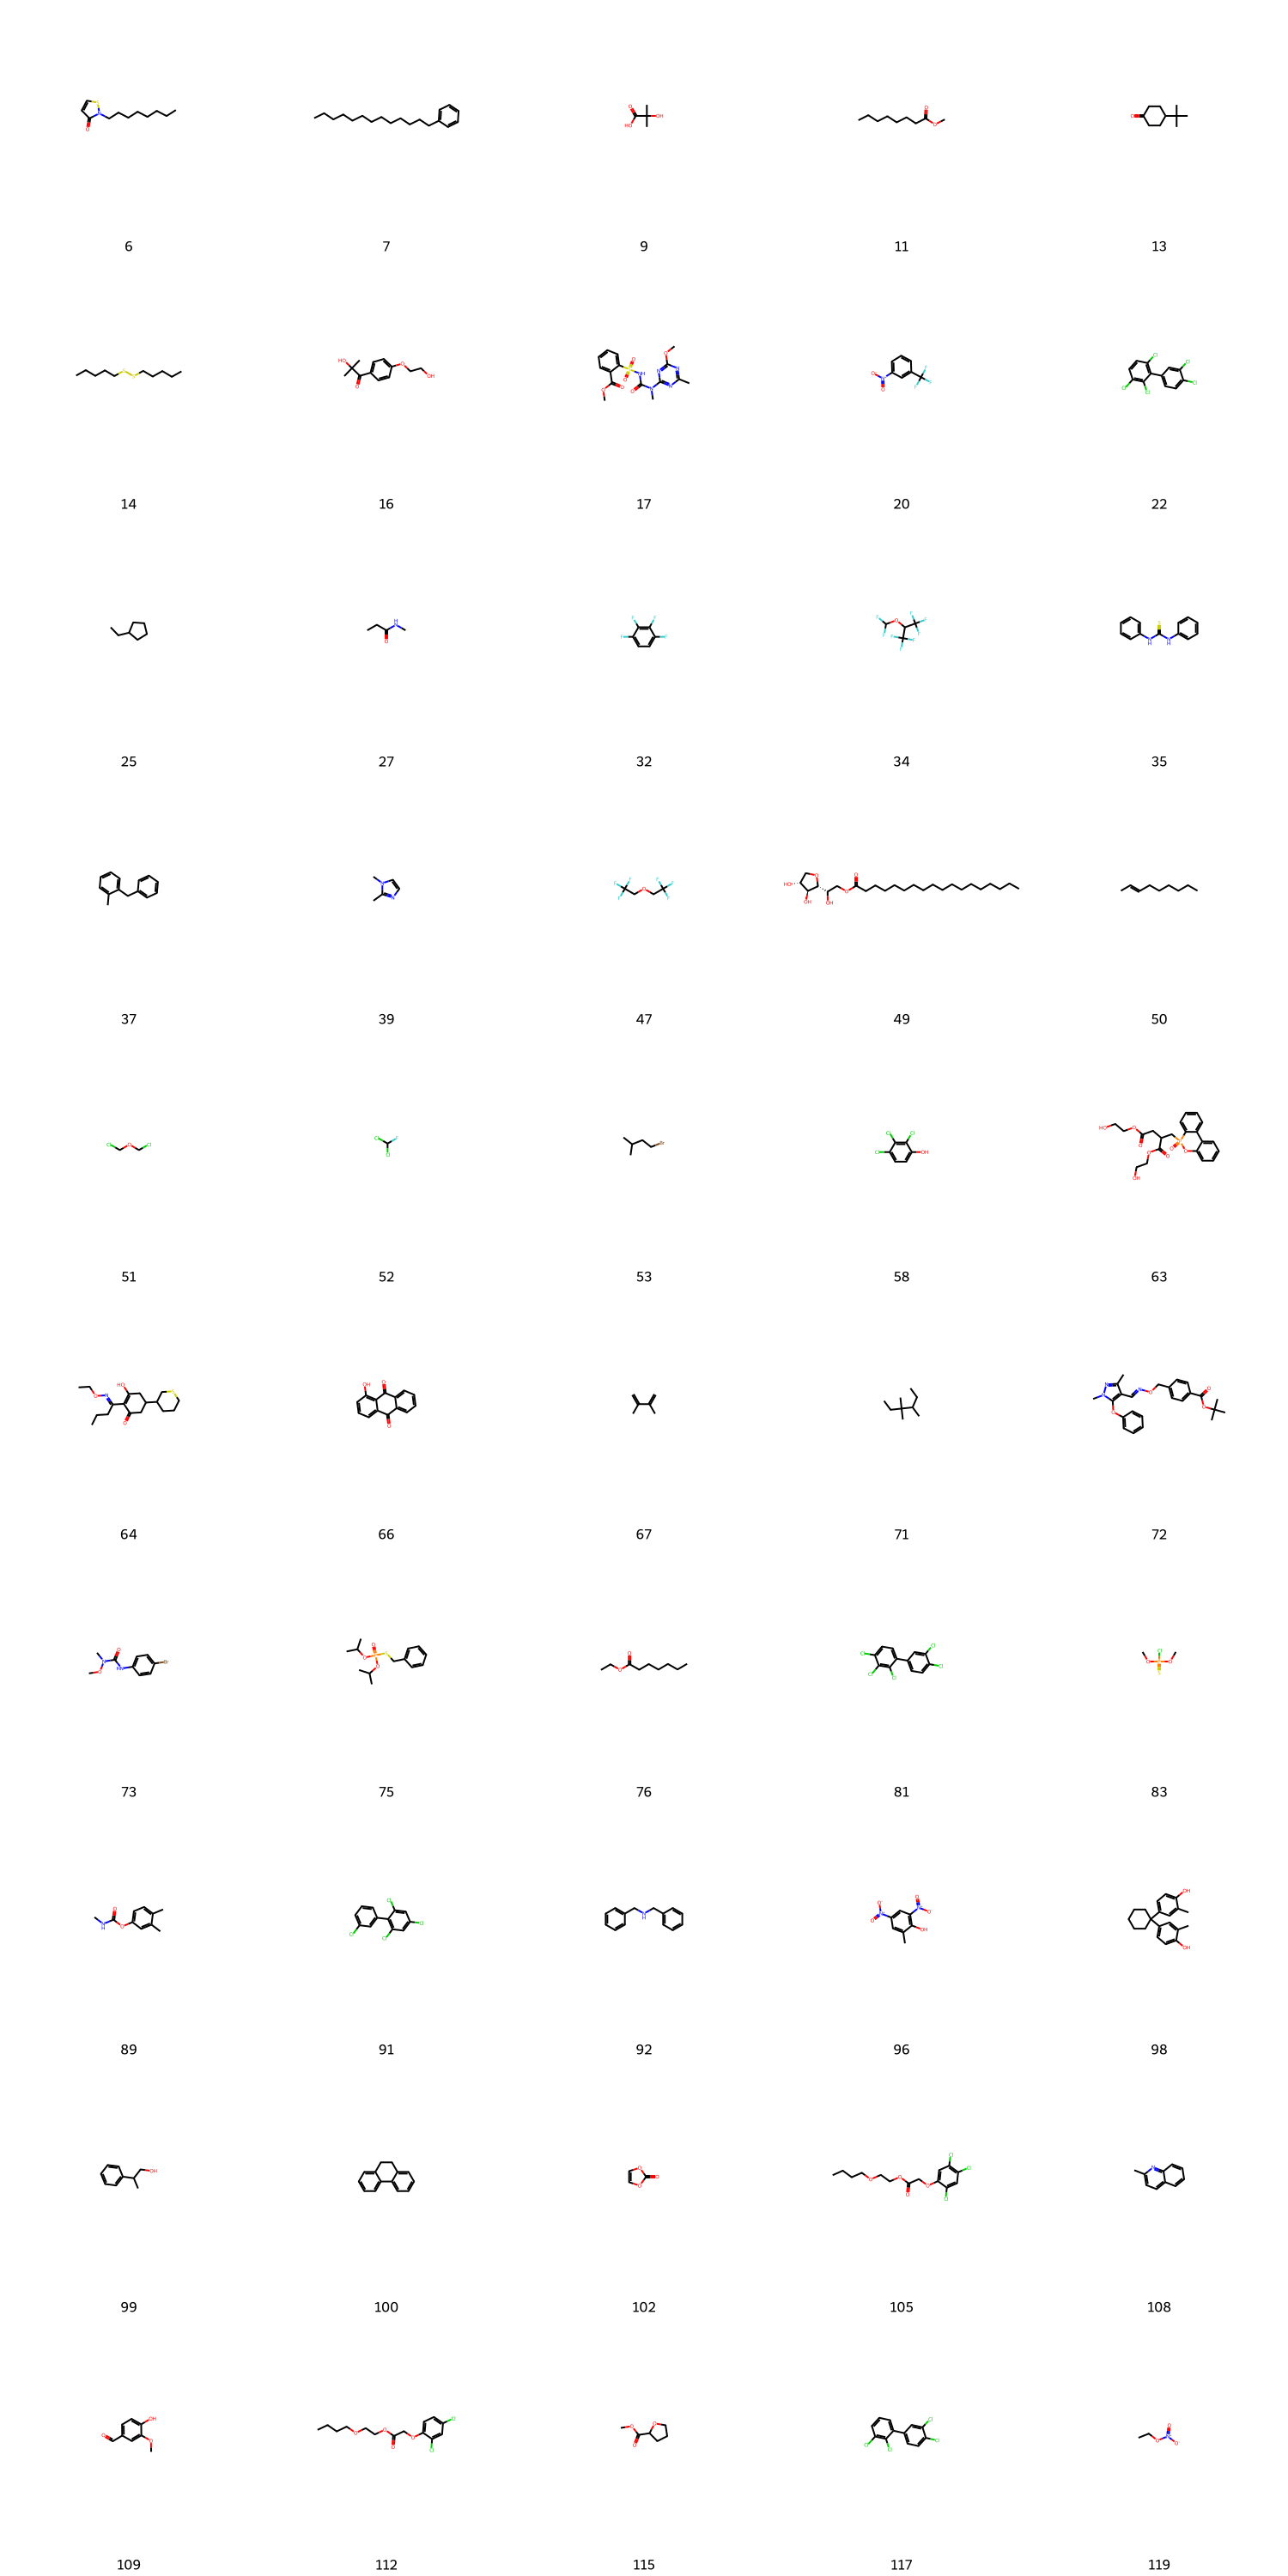

In [16]:
mols = [Chem.MolFromSmiles(s) for s in smiles]
from rdkit.Chem import Draw
Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(300,300), legends=[str(x) for x in molregnos_mdfp_better])

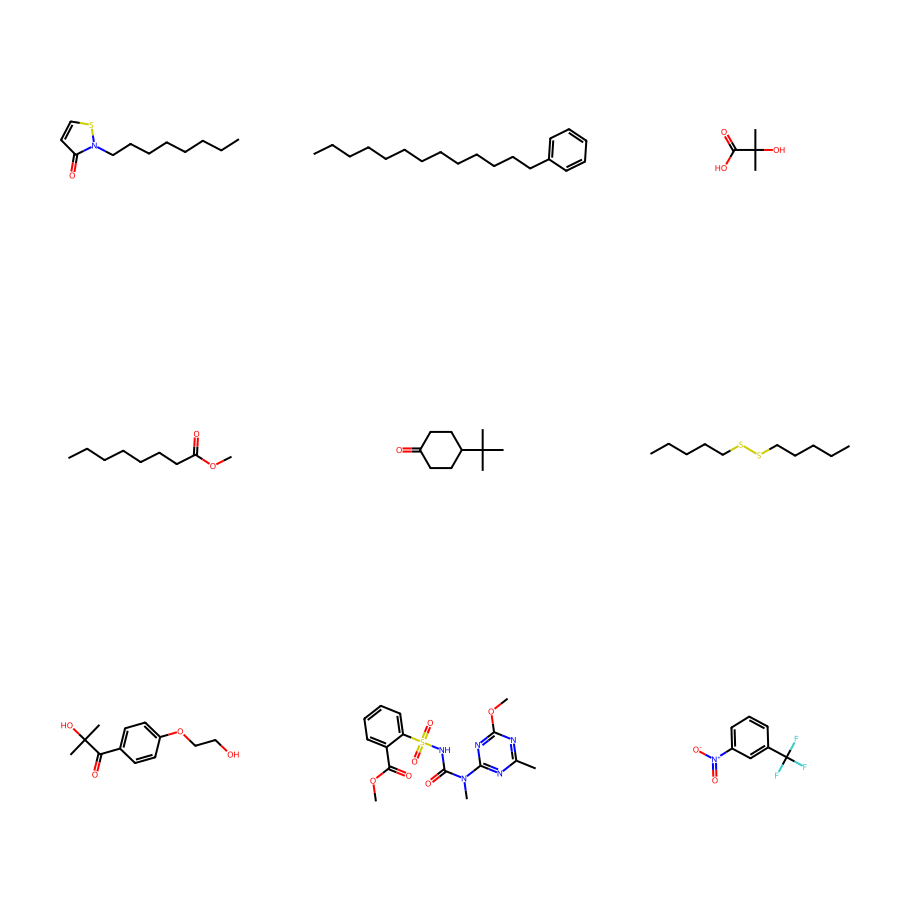

In [17]:
mols = [Chem.MolFromSmiles(s) for s in smiles]
molregnos 
from rdkit.Chem import Draw
Draw.MolsToGridImage(mols[:9], molsPerRow=3, subImgSize=(300,300))

Text(0.5, 1.0, 'Number of molecules per bin of experimental vp values')

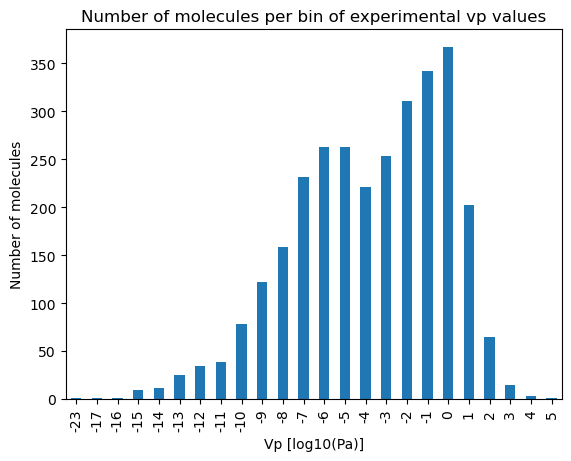

In [18]:
#look at difference in prediction error per bin of experimental vp values. Bin per 1 log unit
df_preds['vp_bin'] = np.floor(df_preds['vp'])
df_preds['vp_bin'] = df_preds['vp_bin'].astype(int)
df_preds['vp_bin'].value_counts()
df_preds['vp_bin'].value_counts().sort_index()
df_preds['vp_bin'].value_counts().sort_index().plot.bar()
plt.ylabel('Number of molecules')
plt.xlabel('Vp [log10(Pa)]')
plt.title('Number of molecules per bin of experimental vp values')


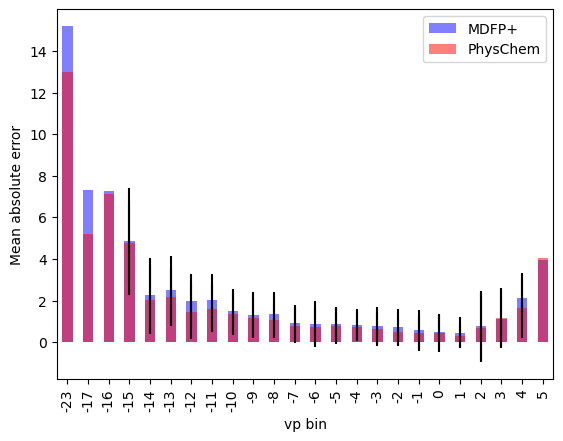

In [19]:
import matplotlib.pyplot as plt

# assuming df_preds is your DataFrame
fig, ax = plt.subplots()
mean_mdfp = df_preds['abs_error_mdfp'].groupby(df_preds['vp_bin']).mean()
std_mdfp = df_preds['abs_error_mdfp'].groupby(df_preds['vp_bin']).std()
mean_2d = df_preds['abs_error_2d'].groupby(df_preds['vp_bin']).mean()
std_2d = df_preds['abs_error_2d'].groupby(df_preds['vp_bin']).std()
datapoints = df_preds['abs_error_2d'].groupby(df_preds['vp_bin']).count()
mean_mdfp.plot.bar(ax=ax, color='blue', alpha=0.5, yerr=std_mdfp)
mean_2d.plot.bar(ax=ax, color='red', alpha=0.5, yerr=std_2d)
ax.legend(['MDFP+','PhysChem'])
ax.set_xlabel('vp bin')
ax.set_ylabel('Mean absolute error')
plt.show()

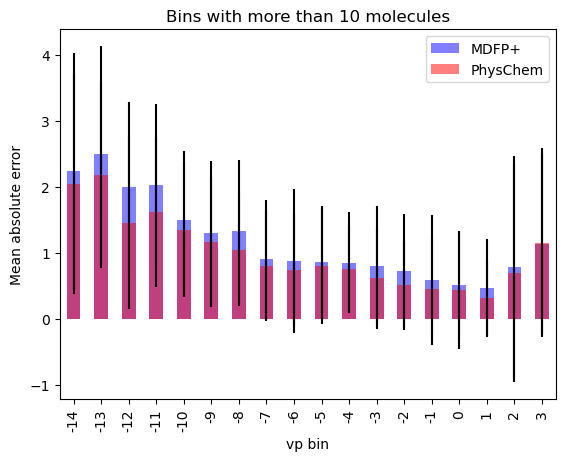

In [20]:
import matplotlib.pyplot as plt

# assuming df_preds is your DataFrame
fig, ax = plt.subplots()
datapoints = df_preds['abs_error_2d'].groupby(df_preds['vp_bin']).count()
bins_with_more_than_50 = datapoints[datapoints > 10].index

mean_mdfp = df_preds[df_preds['vp_bin'].isin(bins_with_more_than_50)]['abs_error_mdfp'].groupby(df_preds['vp_bin']).mean()
std_mdfp = df_preds[df_preds['vp_bin'].isin(bins_with_more_than_50)]['abs_error_mdfp'].groupby(df_preds['vp_bin']).std()
mean_2d = df_preds[df_preds['vp_bin'].isin(bins_with_more_than_50)]['abs_error_2d'].groupby(df_preds['vp_bin']).mean()
std_2d = df_preds[df_preds['vp_bin'].isin(bins_with_more_than_50)]['abs_error_2d'].groupby(df_preds['vp_bin']).std()

mean_mdfp.plot.bar(ax=ax, color='blue', alpha=0.5, yerr=std_mdfp)
mean_2d.plot.bar(ax=ax, color='red', alpha=0.5, yerr=std_2d)
ax.legend(['MDFP+','PhysChem'])
ax.set_xlabel('vp bin')
ax.set_ylabel('Mean absolute error')
ax.set_title('Bins with more than 10 molecules')
plt.show()

/tmp/ipykernel_3979376/1316450871.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  mean_mdfp_percentages = [mean_mdfp[mean_mdfp.index[i]] /mean_mdfp.index[i] * 100 for i in range(len(mean_mdfp))]
/tmp/ipykernel_3979376/1316450871.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  std_mdfp_percentages = [std_mdfp[mean_mdfp.index[i]] /mean_mdfp.index[i] * 100 for i in range(len(mean_mdfp))]
/tmp/ipykernel_3979376/1316450871.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  mean_2d_percentages = [mean_2d[mean_mdfp.index[i]] /mean_mdfp.index[i] * 100 for i in range(len(mean_mdfp))]
/tmp/ipykernel_3979376/1316450871.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  std_2d_percentages = [std_2d[mean_mdfp.index[i]] /mean_mdfp.index[i] * 100 for i in range(len(mean_mdfp))]
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/matplotlib/axes/_axes.py:3680: RuntimeWarning: invalid value encountered in sc

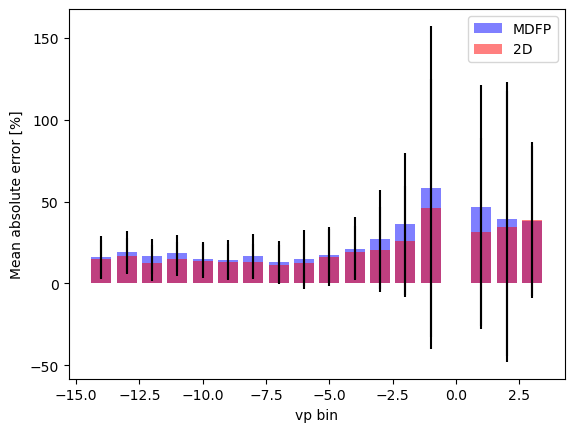

In [21]:
mean_mdfp.index[0]
mean_mdfp_percentages = [mean_mdfp[mean_mdfp.index[i]] /mean_mdfp.index[i] * 100 for i in range(len(mean_mdfp))]
std_mdfp_percentages = [std_mdfp[mean_mdfp.index[i]] /mean_mdfp.index[i] * 100 for i in range(len(mean_mdfp))]
mean_2d_percentages = [mean_2d[mean_mdfp.index[i]] /mean_mdfp.index[i] * 100 for i in range(len(mean_mdfp))]
std_2d_percentages = [std_2d[mean_mdfp.index[i]] /mean_mdfp.index[i] * 100 for i in range(len(mean_mdfp))]
std_2d_percentages = [abs(x) for x in std_2d_percentages]
std_mdfp_percentages = [abs(x) for x in std_mdfp_percentages]
mean_mdfp_percentages = [abs(x) for x in mean_mdfp_percentages]
mean_2d_percentages = [abs(x) for x in mean_2d_percentages]
#barplot
import matplotlib.pyplot as plt
plt, ax = plt.subplots()
ax.bar(mean_mdfp.index, mean_mdfp_percentages, yerr=std_mdfp_percentages, color='blue', alpha=0.5)
ax.bar(mean_2d.index, mean_2d_percentages, yerr=std_2d_percentages, color='red', alpha=0.5)
ax.legend(['MDFP','2D'])
ax.set_xlabel('vp bin')
ax.set_ylabel('Mean absolute error [%]')
# for i, v in enumerate(datapoints):
#     x = mean_2d.index[i]
#     y = mean_mdfp_percentages[i]
#     if str(std_mdfp_percentages[i]) != "nan":
#         y += std_mdfp_percentages[x]
#     ax.text(x, y, str(v), color='black', fontweight='bold', ha='center', va='bottom',fontsize=6)

plt.show()

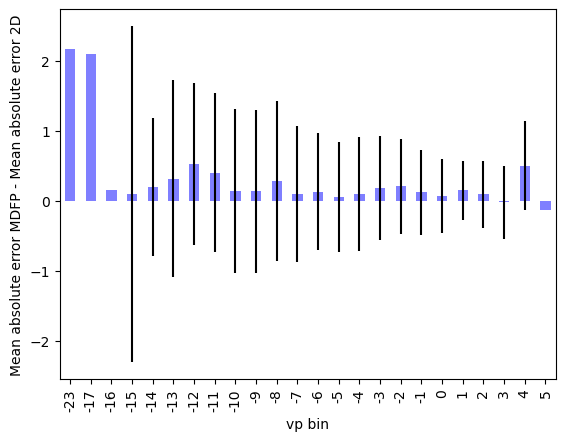

In [22]:
import matplotlib.pyplot as plt

# assuming df_preds is your DataFrame
fig, ax = plt.subplots()
mean_diff = (df_preds['abs_error_mdfp'] - df_preds['abs_error_2d']).groupby(df_preds['vp_bin']).mean()
std_diff = (df_preds['abs_error_mdfp'] - df_preds['abs_error_2d']).groupby(df_preds['vp_bin']).std()
datapoints = (df_preds['abs_error_mdfp'] - df_preds['abs_error_2d']).groupby(df_preds['vp_bin']).count()
mean_diff.plot.bar(ax=ax, color='blue', alpha=0.5, yerr=std_diff)
ax.set_xlabel('vp bin')
ax.set_ylabel('Mean absolute error MDFP - Mean absolute error 2D')
plt.show()

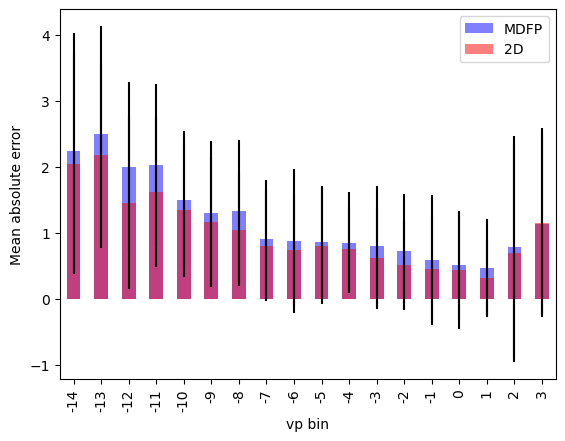

In [23]:
#look only at data with >10 datapoints per bin
#count datapoints per bin
datapoints = df_preds['abs_error_2d'].groupby(df_preds['vp_bin']).count()
bins_with_10_datapoints = datapoints[datapoints > 10].index.tolist()    

import matplotlib.pyplot as plt
#plot only bins with >10 datapoints
# assuming df_preds is your DataFrame
fig, ax = plt.subplots()
df_preds_10 = df_preds[df_preds['vp_bin'].isin(bins_with_10_datapoints)]
mean_mdfp = df_preds_10['abs_error_mdfp'].groupby(df_preds_10['vp_bin']).mean()
std_mdfp = df_preds_10['abs_error_mdfp'].groupby(df_preds_10['vp_bin']).std()
mean_2d = df_preds_10['abs_error_2d'].groupby(df_preds_10['vp_bin']).mean()
std_2d = df_preds_10['abs_error_2d'].groupby(df_preds_10['vp_bin']).std()
datapoints = df_preds_10['abs_error_2d'].groupby(df_preds_10['vp_bin']).count()
mean_mdfp.plot.bar(ax=ax, color='blue', alpha=0.5, yerr=std_mdfp)
mean_2d.plot.bar(ax=ax, color='red', alpha=0.5, yerr=std_2d)
ax.legend(['MDFP','2D'])
ax.set_xlabel('vp bin')
ax.set_ylabel('Mean absolute error')
plt.show()




In [24]:
import sys
sys.path.append('../')
from carl.utils_carl import get_mdfps
df_mdfps = get_mdfps(which='one_5ns')
df_new_confs = get_mdfps(which='five_5ns')

data_full = pd.concat([df_mdfps,df_new_confs])

2980 results fetched
['confid', 'molregno', 'mdfp', 'vp_log10pa']
11023 results fetched
['confid', 'molregno', 'mdfp', 'vp_log10pa']


In [25]:
df_physchem = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/Experiments_result_analysis/mdfp_and_rdkit_features_2980.csv')
RDKit_feature_names = pd.read_pickle('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/outputs/RDKit_2D_descriptors.pkl')

In [26]:
#get a dict mapping molregno to each feature
molregno_to_physchem = {}
for i in range(len(df_physchem)):
    molregno_to_physchem[df_physchem['molregno'].iloc[i]] = df_physchem.iloc[i].to_dict()

In [27]:
molregnos = data_full['molregno'].tolist()
for feature in RDKit_feature_names:
    l1 = []
    for molregno in molregnos:
        l1.append(molregno_to_physchem[molregno][feature])
    data_full[feature] = l1
data_full.to_csv('mdfp_and_rdkit_features_augmented.csv')


/tmp/ipykernel_3979376/458539693.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_full[feature] = l1
/tmp/ipykernel_3979376/458539693.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_full[feature] = l1
/tmp/ipykernel_3979376/458539693.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


In [28]:
import pandas as pd
#split list in column "mdfp" into seperate columns: column names from mdfp_feature_names
mdfp_features_all = ['NumHeavyAtoms', 'NumRotatableBonds', 'NumN', 'NumO', 'NumF', 'NumP', 'NumS', 'NumCl', 'NumBr', 'NumI', 'water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean', 'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std', 'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median', 'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean', 'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std', 'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']

# use apply method to split the list into separate columns
data_full[mdfp_features_all] = data_full['mdfp'].apply(lambda x: pd.Series(x))

# print the resulting dataframe


/tmp/ipykernel_3979376/2822372413.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_full[mdfp_features_all] = data_full['mdfp'].apply(lambda x: pd.Series(x))
/tmp/ipykernel_3979376/2822372413.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_full[mdfp_features_all] = data_full['mdfp'].apply(lambda x: pd.Series(x))
/tmp/ipykernel_3979376/2822372413.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining 

In [29]:
data_full

,confid,molregno,mdfp,vp,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,...,water_intra_ene_median,water_total_ene_mean,water_total_ene_std,water_total_ene_median,water_rgyr_mean,water_rgyr_std,water_rgyr_median,water_sasa_mean,water_sasa_std,water_sasa_median
0,2388,2390,"[10, 1, 0, 0, 0, 0, 0, 0, 0, 0, -24.3637634540...",2.325205,8.278588,8.278588,1.227955,-4.010932,0.519119,136.238,...,5.081368,-72.161483,10.529911,-72.402603,0.239207,0.001838,0.239275,3.536894,0.017106,3.536101
1,2394,2396,"[7, 4, 0, 1, 0, 0, 0, 0, 0, 0, -4.742220929815...",2.092080,7.449583,7.449583,3.420840,-3.969792,0.533928,102.177,...,4.578916,-99.110528,13.121092,-99.618129,0.234266,0.012069,0.233745,3.125541,0.054318,3.125999
2,2400,2402,"[10, 2, 2, 0, 0, 0, 0, 0, 0, 0, -13.4724999801...",0.000000,8.560843,8.560843,0.020648,-2.797595,0.620495,132.166,...,10.904916,-127.549064,15.489246,-127.568218,0.258037,0.011765,0.264010,3.292758,0.020541,3.296084
3,2406,2408,"[14, 3, 4, 3, 0, 0, 0, 0, 0, 0, -411.884680244...",-3.822020,11.649018,11.649018,0.734623,-3.552775,0.464456,198.182,...,-388.562189,-648.902490,21.619238,-648.956024,0.332311,0.004967,0.332628,4.316147,0.032678,4.317026
4,2411,2413,"[15, 2, 0, 1, 0, 0, 0, 0, 2, 0, -36.3113182099...",-1.772345,7.904480,7.904480,0.039061,-0.571335,0.753483,328.003,...,12.365653,-111.465809,13.073721,-112.106635,0.377372,0.009262,0.378641,4.357666,0.036732,4.363505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11018,15530,3539,"[44, 35, 2, 4, 0, 0, 0, 0, 0, 0, -285.66340740...",-4.000000,13.957175,13.957175,1.977423,-5.728258,0.052766,625.036,...,-252.296929,-733.750337,34.435179,-735.575589,0.589540,0.094679,0.555212,10.255381,1.258854,9.802786
11019,15531,3539,"[44, 35, 2, 4, 0, 0, 0, 0, 0, 0, -287.85335624...",-4.000000,13.957175,13.957175,1.977423,-5.728258,0.052766,625.036,...,-247.606477,-744.157699,35.189823,-741.307864,0.626359,0.099946,0.592080,10.617662,1.170149,10.240599
11020,15529,3539,"[44, 35, 2, 4, 0, 0, 0, 0, 0, 0, -286.74305751...",-4.000000,13.957175,13.957175,1.977423,-5.728258,0.052766,625.036,...,-248.307237,-736.424789,31.662713,-735.567623,0.605228,0.042678,0.609659,10.298609,0.532040,10.232232
11021,15532,3539,"[44, 35, 2, 4, 0, 0, 0, 0, 0, 0, -284.52836303...",-4.000000,13.957175,13.957175,1.977423,-5.728258,0.052766,625.036,...,-246.526330,-738.644704,33.504635,-739.978177,0.607021,0.133031,0.544421,10.257882,1.261011,9.716675


In [30]:
#okay, now I actually want to look at prediction error of only 2d vs only mdfp per mol, and look at the difference
df = data_full
params = {
    'max_depth':9,
    'min_child_weight': 4,
    'eta':.05,
    'subsample': 1,
    'colsample_bytree': 0.5,
} #hyperparameters optimized for augmented dataset
import numpy as np
from sklearn.model_selection import GroupKFold, KFold
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
gkf = GroupKFold(n_splits=5)

# Create an empty list to store the indices of each fold
fold_indices = []
# Group the data by 'molregno'
groups = df['molregno']

# Iterate over each fold
for train_idx, test_idx in gkf.split(df, groups=groups):
    fold_indices.append((train_idx, test_idx))
mdfp_features_all = ['NumHeavyAtoms', 'NumRotatableBonds', 'NumN', 'NumO', 'NumF', 'NumP', 'NumS', 'NumCl', 'NumBr', 'NumI', 'water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean', 'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std', 'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median', 'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean', 'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std', 'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']
combined_features = RDKit_feature_names + mdfp_features_all
y = df['vp']  
params = params
output = ([],[],[],[],[],[])
selection_2d_features = RDKit_feature_names

X_mdfp = df[mdfp_features_all]
X_mdfp = StandardScaler().fit_transform(X_mdfp)
X_2d = df[selection_2d_features]
X_2d = StandardScaler().fit_transform(X_2d)
x_combined = df[combined_features]
x_combined = StandardScaler().fit_transform(x_combined)
y = df['vp'].to_numpy()
# Iterate over each fold
for fold, (train_idx, test_idx) in enumerate(fold_indices):

    #get the train and test data
    X_train_mdfp = X_mdfp[train_idx]
    X_test_mdfp = X_mdfp[test_idx]
    X_train_2d = X_2d[train_idx]
    X_test_2d = X_2d[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    X_train_combined = x_combined[train_idx]
    X_test_combined = x_combined[test_idx]




    # Create DMatrix for training and testing
    dtrain_mdfp = xgb.DMatrix(X_train_mdfp, label=y_train)
    dtest_mdfp = xgb.DMatrix(X_test_mdfp, label=y_test)

    dtrain_2d = xgb.DMatrix(X_train_2d, label=y_train)
    dtest_2d = xgb.DMatrix(X_test_2d, label=y_test)

    dtrain_combined = xgb.DMatrix(X_train_combined, label=y_train)
    dtest_combined = xgb.DMatrix(X_test_combined, label=y_test)


    model_mdfp = xgb.train(
        params,
        dtrain_mdfp,
        num_boost_round=999,
        evals=[(dtest_mdfp, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False

    )

    model_2d = xgb.train(
        params,
        dtrain_2d,
        num_boost_round=999,
        evals=[(dtest_2d, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False

    )

    model_combined = xgb.train(
        params,
        dtrain_combined,
        num_boost_round=999,
        evals=[(dtest_combined, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False

    )

    pp_mdfp = model_mdfp.predict(dtest_mdfp)
    pp_2d = model_2d.predict(dtest_2d)
    pp_combined = model_combined.predict(dtest_combined)

    output[0].append(y_test)
    output[1].append(pp_mdfp)
    molregnos_test = df['molregno'].iloc[test_idx]
    confids_test = df['confid'].iloc[test_idx]
    
    output[2].append(molregnos_test)
    output[3].append(confids_test)
    output[4].append(pp_2d)
    output[5].append(pp_combined)

    rmse_mdfp = np.sqrt(mean_squared_error(y_test, pp_mdfp, squared=False))
    rmse_2d = np.sqrt(mean_squared_error(y_test, pp_2d, squared=False))
    rmse_combined = np.sqrt(mean_squared_error(y_test, pp_combined, squared=False))
    print(f"Fold {fold + 1}: MDFP RMSE = {rmse_mdfp}, 2D RMSE = {rmse_2d}, combined RMSE = {rmse_combined}")



Fold 1: MDFP RMSE = 1.1784476874986825, 2D RMSE = 1.142497427080294, combined RMSE = 1.1475896171725948
Fold 2: MDFP RMSE = 1.2505413639309084, 2D RMSE = 1.1673159236443984, combined RMSE = 1.1923054555086903
Fold 3: MDFP RMSE = 1.0953961131419252, 2D RMSE = 1.0340732635816368, combined RMSE = 1.0363057884060818
Fold 4: MDFP RMSE = 1.101377801689998, 2D RMSE = 1.0637572857383766, combined RMSE = 1.0641393943562079
Fold 5: MDFP RMSE = 1.2685576864752095, 2D RMSE = 1.1557867139856672, combined RMSE = 1.1518344605504791


In [31]:
#average over conformers
vps = reduce(lambda a,b : list(a)+list(b) , output[0])
preds_mdfp = reduce(lambda a,b : list(a)+list(b), output[1])
molregnos = reduce(lambda a,b : list(a)+list(b), output[2])
confids = reduce(lambda a,b : list(a)+list(b), output[3])
preds_2d = reduce(lambda a,b : list(a)+list(b), output[4])
preds_combined = reduce(lambda a,b : list(a)+list(b), output[5])
df_preds = pd.DataFrame({'vp': vps, 'pred_mdfp': preds_mdfp, 'pred_2d': preds_2d, 'confid': confids, 'molregno': molregnos, 'pred_combined': preds_combined})
df_preds = df_preds.groupby('molregno').mean()
#drop confid
df_preds = df_preds.drop(columns=['confid'])
#get abs error for both preds
df_preds['abs_error_mdfp'] = abs(df_preds['vp'] - df_preds['pred_mdfp'])
df_preds['abs_error_2d'] = abs(df_preds['vp'] - df_preds['pred_2d'])
df_preds['abs_error_combined'] = abs(df_preds['vp'] - df_preds['pred_combined'])
df_preds

,vp,pred_mdfp,pred_2d,pred_combined,abs_error_mdfp,abs_error_2d,abs_error_combined
molregno,,,,,,,
1,4.100855,4.012758,4.077096,3.925213,0.088097,0.023759,0.175642
6,-11.744727,-4.949354,-5.683266,-5.264895,6.795374,6.061461,6.479833
7,2.698933,2.446294,2.836136,2.783381,0.252639,0.137203,0.084447
8,-3.053323,-3.076710,-3.012222,-2.932419,0.023387,0.041100,0.120904
9,3.591625,3.422963,3.616429,3.424995,0.168662,0.024805,0.166630
...,...,...,...,...,...,...,...
4240,-4.301899,-4.221007,-4.323608,-4.519409,0.080893,0.021709,0.217509
4241,-5.356584,-5.229311,-5.600667,-5.609240,0.127273,0.244083,0.252655
4242,-3.770000,-3.579237,-3.558295,-3.610788,0.190763,0.211705,0.159212


Spearman: 0.95
Plot 1 Stats:
RMSE:  1.3253927068866616
MAE:  0.7793149760120497
R2:  0.8655926563636731
Spearman: 0.96
Plot 2 Stats:
RMSE:  1.1884236908671935
MAE:  0.6661001939822048
R2:  0.8919749535817786
Spearman: 0.96
Plot 3 Stats:
RMSE:  1.1975270685316988
MAE:  0.6636903752840874
R2:  0.8903371154687588


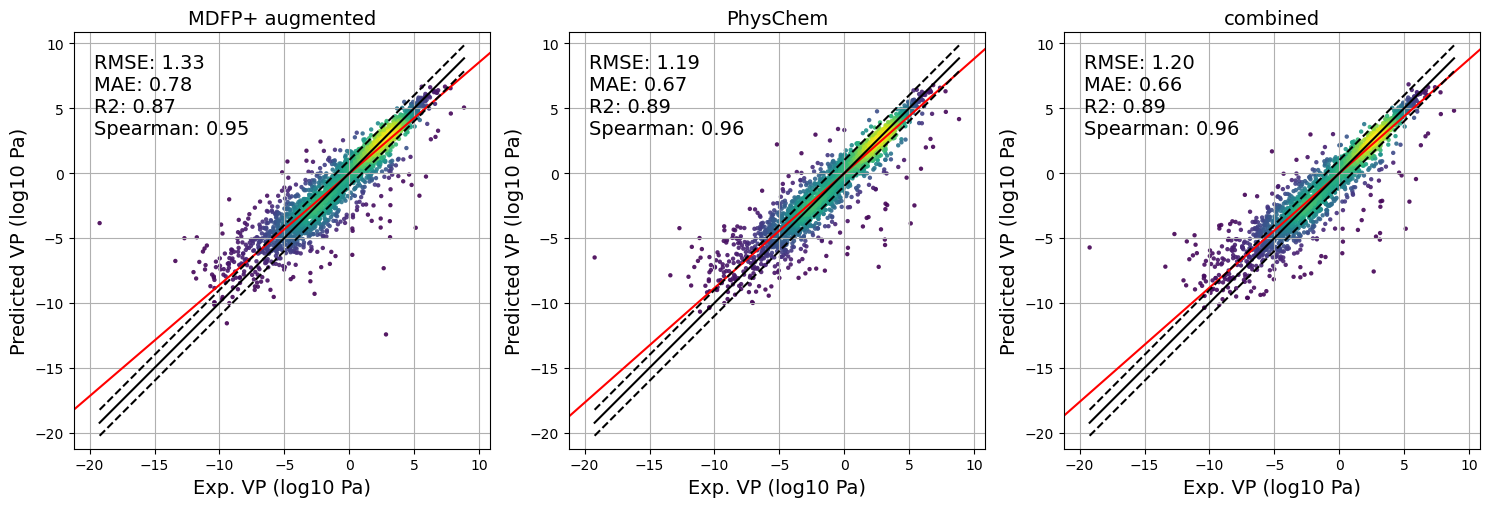

In [33]:
real = df_preds['vp'].tolist()
prediction_mdfp = df_preds['pred_mdfp'].tolist()
prediction_2d = df_preds['pred_2d'].tolist()
prediction_combined = df_preds['pred_combined'].tolist()
density_plot_multiple(reals = [real,real,real],predictions=[prediction_mdfp,prediction_2d,prediction_combined],titles = ['MDFP+ augmented','PhysChem','combined'],print_spearman=True)

0.9484301082403844
PearsonRResult(statistic=0.930372321365846, pvalue=0.0)


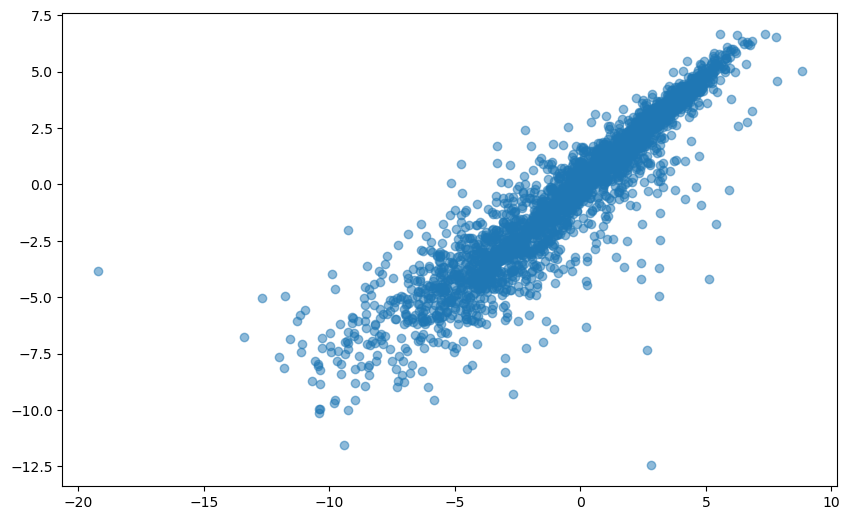

In [44]:
from scipy.stats import spearmanr,pearsonr



Spearman: 0.89
Plot 1 Stats:
RMSE:  1.2968077389635706
MAE:  0.877910000243293
R2:  0.7757295679384085
Spearman: 0.92
Plot 2 Stats:
RMSE:  1.1754600858615174
MAE:  0.7678468302197026
R2:  0.8155669312900503
Spearman: 0.92
Plot 3 Stats:
RMSE:  1.1807182687811693
MAE:  0.7636944202239342
R2:  0.8134687687822721


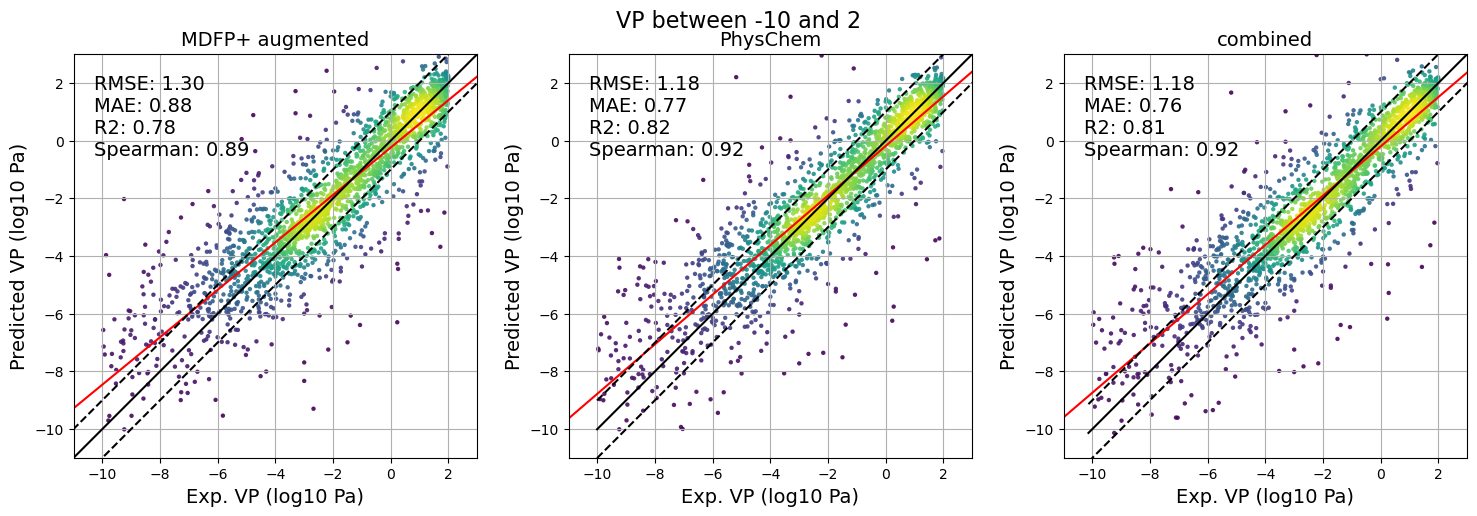

In [70]:
#look only at vp between -10 and 2
df_tmp = df_preds[(df_preds['vp'] > -10) & (df_preds['vp'] < 2)]
real = df_tmp['vp'].tolist()
prediction_mdfp = df_tmp['pred_mdfp'].tolist()
prediction_2d = df_tmp['pred_2d'].tolist()
prediction_combined = df_tmp['pred_combined'].tolist()
density_plot_multiple(reals = [real,real,real],predictions=[prediction_mdfp,prediction_2d,prediction_combined],titles = ['MDFP+ augmented','PhysChem','combined'],print_spearman=True,global_title='VP between -10 and 2', bounds=[-11,3])

In [59]:
reals = [real,real,real]
from scipy import stats
predictions=[prediction_mdfp,prediction_2d,prediction_combined]
labels = ['MDFP+ augmented','PhysChem','combined']
def funky_rmses(y_true, y_pred):
    errors = [true - pred for true, pred in zip(y_true, y_pred)]
    squared_errors = [np.square(x) for x in errors]
    RMeanSE = np.sqrt(np.mean(squared_errors))
    RStdSE = np.sqrt(np.std(squared_errors))
    RMedianSET = np.sqrt(np.median(squared_errors))
    return RMeanSE, RStdSE, RMedianSET
    
def funky_maes(y_true, y_pred):
    errors = [np.abs(true - pred) for true, pred in zip(y_true, y_pred)]
    RMeanAE = np.mean(errors)
    RStdAE = np.std(errors)
    RMedianAE = np.median(errors)
    return RMeanAE, RStdAE, RMedianAE

for real,pred,label in zip(reals,predictions,labels):

    RMeanSE, RStdSE, RMedianSET = funky_rmses(real, pred)
    RMeanAE, RStdAE, RMedianAE = funky_maes(real, pred)
    #print results with description
    print(label)
    print(f"RMSE: {RMeanSE:.2f} ± {RStdSE:.2f} ({RMedianSET:.2f})")
    print(f"MAE: {RMeanAE:.2f} ± {RStdAE:.2f} ({RMedianAE:.2f})")
    #print spearman
    print(f"Spearman: {stats.spearmanr(real, pred)[0]:.2f}")


MDFP+ augmented
RMSE: 1.33 ± 2.81 (0.40)
MAE: 0.78 ± 1.07 (0.40)
Spearman: 0.95
PhysChem
RMSE: 1.19 ± 2.42 (0.31)
MAE: 0.67 ± 0.98 (0.31)
Spearman: 0.96
combined
RMSE: 1.20 ± 2.47 (0.29)
MAE: 0.66 ± 1.00 (0.29)
Spearman: 0.96


In [57]:
errors = [true - pred for true, pred in zip(real,pred)]
absolute_errors = [abs(x) for x in errors]
squared_errors = [np.square(x) for x in errors]


median_relative_error = np.median(errors)
median_absolute_error = np.median(absolute_errors)
median_squared_error = np.median(squared_errors)
root_median_squared_error = np.sqrt(median_squared_error)

mean_relative_error = np.mean(errors)
mean_absolute_error = np.mean(absolute_errors)
mean_squared_error = np.mean(squared_errors)
root_mean_squared_error = np.sqrt(mean_squared_error)


print(f'median relative error: {median_relative_error}')
print(f'median absolute error: {median_absolute_error}')
print(f'median squared error: {median_squared_error}')
print(f'root median squared error: {root_median_squared_error}')

print(f'(median(ers))² = {np.square(np.median(errors))}')
print(f'root(median(ers))² = {np.sqrt(np.square(np.median(errors)))}')

print('\n')
print(f'mean relative error: {mean_relative_error}')
print(f'mean absolute error: {mean_absolute_error}')
print(f'mean squared error: {mean_squared_error}')
print(f'root mean squared error: {root_mean_squared_error}')


median relative error: 0.020736258547171982
median absolute error: 0.2921971333394848
median squared error: 0.08537920102117633
root median squared error: 0.2921971954368767
(median(ers))² = 0.0004299924185351631
root(median(ers))² = 0.020736258547171982


mean relative error: -0.011705467557288027
mean absolute error: 0.6636903752840874
mean squared error: 1.4340710798661238
root mean squared error: 1.1975270685316988


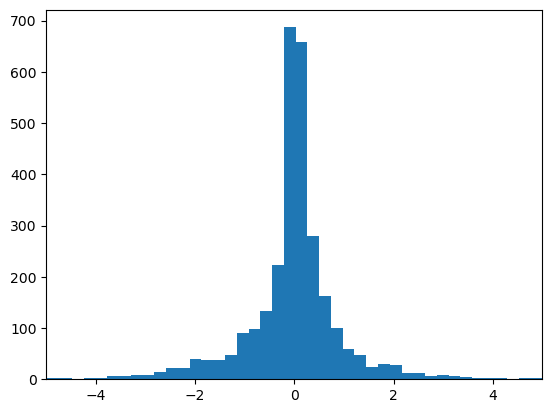

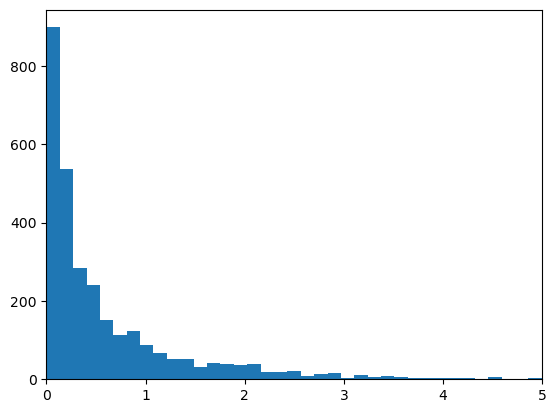

In [50]:
#plot error as histogram
plt.hist(errors, bins=100)
plt.xlim(-5,5)
plt.show()
plt.hist(absolute_errors, bins=100)
plt.xlim(0,5)
plt.show()


In [65]:
#custom features: NumHeavyAtoms, NumHBondDonors,NumHBondAcceptors

custom_features = ['NumHeavyAtoms', 'NumHAcceptors', 'NumHDonors']
output_custom = train_pred_xgboost_2d(df,params=params,X_features=custom_features,y_label='vp')
real_custom, prediction_custom = (reduce(lambda a,b : list(a)+list(b) , output_custom[0]), reduce(lambda a,b : list(a)+list(b), output_custom[1]))


Plot 1 Stats:
RMSE:  1.2240529735051782
MAE:  0.7530258437360301
R2:  0.8852345251786184
Plot 2 Stats:
RMSE:  1.6428743848336376
MAE:  1.1529937310021678
R2:  0.7939433022260703


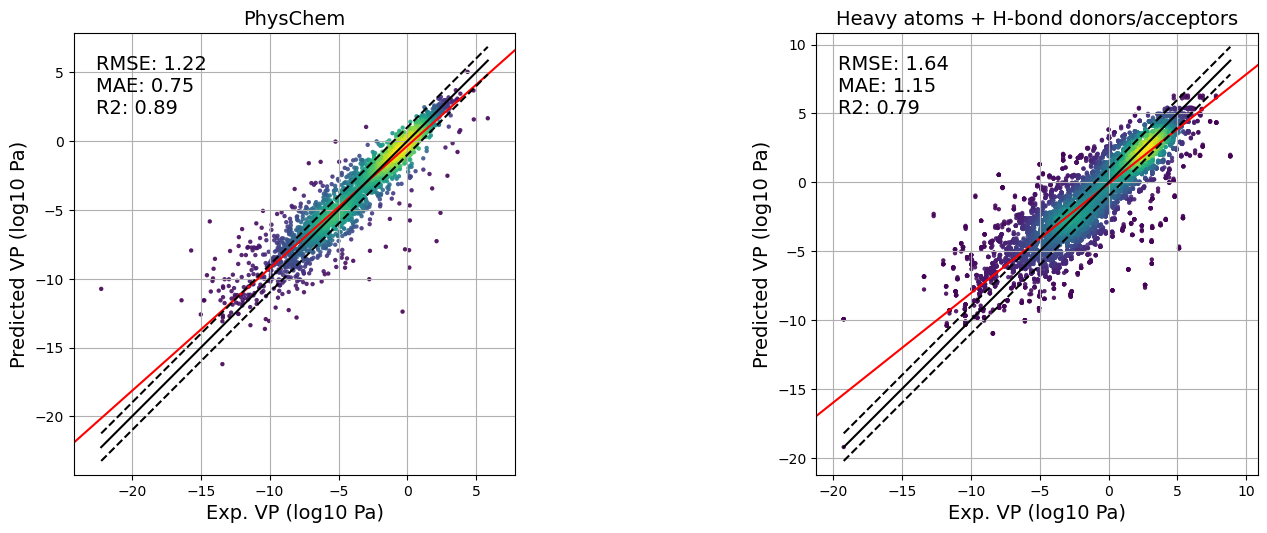

In [69]:
density_plot_multiple(reals = [real_2d_only, real_custom] ,predictions= [prediction_2d_only,prediction_custom],titles = ["PhysChem",'Heavy atoms + H-bond donors/acceptors'])